# _Why bother to learn about mixture models?_ 
# _Why use them, what's the benefit of the extra effort to learn these techniques?_
# _How can they be applied to trading?_

#### `In this chapter I'll set out to answer these questions by demonstrating the challenges inherent to time series prediction.`

### Import modules and tools

In [20]:
%load_ext watermark
%watermark

# import standard libs

import sys
import os
import time

# import python scientific stack

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
import pymc3 as pm

# import visual tools

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# set globals
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['figure.figsize'] = 9,7

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777
dfwaic = pd.DataFrame() # setup for WAIC evaluations

print()
%watermark -p pymc3,pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-10-27T22:13:20-06:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.0-97-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit

pymc3 3.1
pandas 0.20.3
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 0.19.1
matplotlib 2.0.2
seaborn 0.8.1
plotnine 0.2.1+13.g65bdce6
pyarrow 0.7.0


# Notes:

- create legend for all multi distro plots
- add explanatory text between images

In [3]:
# some conv fns

def cprint(df):
    print('-'*79)
    print('dataframe information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)    
    print()
    
get_range = lambda df, col: (df[col].min(), df[col].max())

#### `First let's get some market data from Yahoo. We'll get the adjusted closing price for multiple ETFs. `

In [4]:
get_price = lambda sym, start, end: web.DataReader(sym, 'yahoo', start, end)['Adj Close']

chosen_syms = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

end = pd.to_datetime('2017-09-30')
start = end - 25 * 252 * pd.tseries.offsets.BDay()

#%time df = (pd.DataFrame({sym:get_price(sym, start, end) for sym in chosen_syms}).dropna())
#cprint(df)

#### `Next we create the return dataframe and save it using pyarrow. `

`Please note that although this dataset is small enough to save as csv or h5, if you intend on dealing with larger datasets aka "big data" on "distributed systems" I recommend developing the pyarrow habit now. This will save you time and storage costs down the road.`

In [5]:
#rs = np.log(df/df.shift(1)).dropna()
#cprint(rs)

In [6]:
save_parquet = lambda df, save_fp: pq.write_table(pa.Table.from_pandas(df), save_fp)

pdir = '/media/files/_Code/mixture_model_trading/'
#save_fp = pdir + f'data/etf_returns_{rs.index.min().date()}-{rs.index.max().date()}.parquet'
#save_parquet(rs, save_fp)

In [7]:
load_parquet = lambda fp: pq.read_table(fp)

load_fp = pdir+'data/etf_returns_2004-11-19-2017-09-29.parquet'
rs = (load_parquet(load_fp)
      .to_pandas()
      .assign(year=lambda df: df.index.year)) # add year column for later conv.
cprint(rs)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               EEM     EFA     GLD     QQQ     SPY     TLT  year
Date                                                            
2017-09-25 -0.0171 -0.0057  0.0104 -0.0106 -0.0020  0.0062  2017
2017-09-26 -0.0027 -0.0022 -0.0112  0.0026  0.0006 -0.0018  2017
2017-09-27 -0.0036  0.0007 -0.0095  0.0090  0.0039 -0.0152  2017
2017-09-28 -0.0007  0.0026  0.0019 -0.0003  0.0012 -0.0030  2017
2017-09-29  0.0114  0.0059 -0.0052  0.0072  0.0035  0.0022  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 7 columns):
EEM     3238 non-null float64
EFA     3238 non-null float64
GLD     3238 non-null float64
QQQ     3238 non-null float64
SPY     3238 non-null float64
TLT     3238 non-null float64
year    

## What is stationary data?

`The following image sums up this concept best. The simple intuition is that the series mean and variance should NOT change as a result of passing time. The covariance between returns in the time series should also NOT be a function of time.`

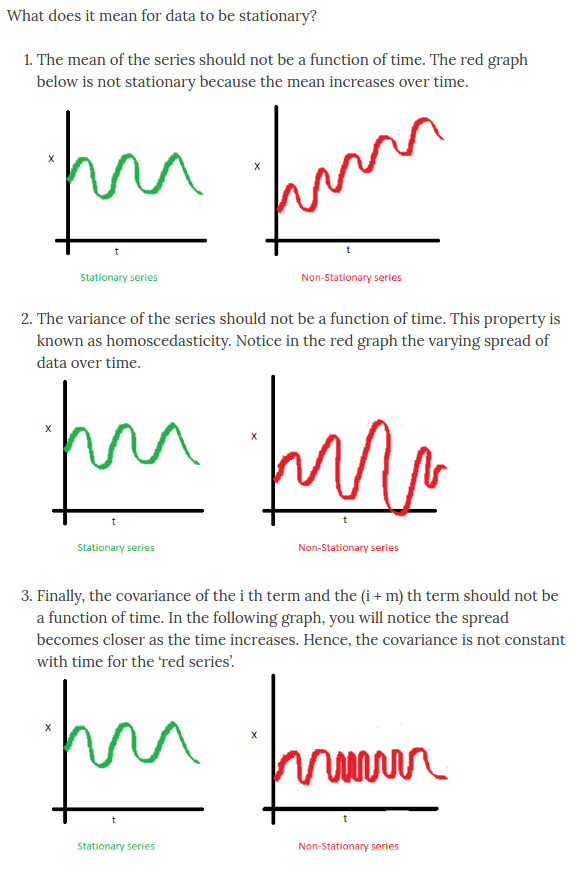

In [8]:
from IPython.display import Image

media = '/home/cam/Documents/Brian_/HDD_folders/_Code/mixture_model_trading/visuals/01_Motivation/stationarity infographic screenshot-www.seanabu.com-2016-11-01-14-16-35.png'
Image(media)

#### `Now that you are familiarized with the concept of stationary time series, I will use the remainder of this notebook to demonstrate/discuss some of the nuances and challenges one runs into in application. Just know that the behavior of securities' returns challenges these requirements of stationarity and our attempts to predict them in ways that are sometimes unknowable. This is a very humbling realization but is a necessary fact that requires a strategic response in the practice of return prediction.`

`The remainder of this notebook will use the canonical **SPY** etf as the primary example but I urge you to download the notebook and experiment with the other securities.`

`Below I define some convenience functions for plotting.`

In [9]:
def add_mean_std_text(x, **kwargs):
    """fn: add mean, std text to seaborn plot
    
    # Args
        x : pd.Series()
    """
    mean, std = x.mean(), x.std()
    mean_tx = f"mean: {mean:.4%}\nstd: {std:.4%}"
    
    txkw = dict(size=14, fontweight='demi', color='red', rotation=0)
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.8*ymax, mean_tx, **txkw)
    return

def plot_dist(rs, ex):
    """fn: to plot single distro with fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """    
    plt.style.use('dark_background')
    plt.rcParams['font.size'] = 14
    g = (rs
         .pipe(sns.FacetGrid, 
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':green, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':gold, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))
    g.add_legend()
    sns.despine(offset=1)
    plt.title(f'{ex} returns')
    return
    
def plot_facet_hist(rs, ex):
    """fn: to plot multiple fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """
    plt.style.use('dark_background')
    
    plt.rcParams['font.size'] = 12
    df = rs.assign(year=lambda df: df.index.year)
    g = (sns.FacetGrid(df, col='year',col_wrap=2, size=4, aspect=1.2) # make sure to add legend
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':green, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':gold, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))

    g.add_legend()
    g.fig.subplots_adjust(hspace=.20)
    sns.despine(offset=1)
    return

#### `First let's address the concept of normality. Are SPY returns normally distributed? (short answer: sometimes)`

`Let's look at the entire return distribution of SPY as a histogram using seaborn's distplot. You'll notice that I have layered fitted density plots using the following distributions: *normal*, *laplace*, and *johnsonsu*.`

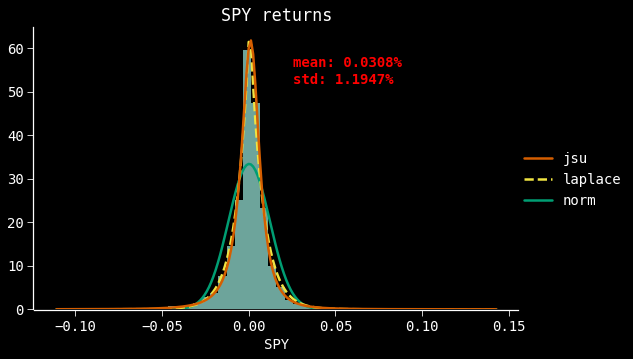

In [10]:
ex = 'SPY'
df = rs.loc['2005':].copy() # use 2005 cutoff b/c it's first full year of data

plot_dist(df, ex)

`Looking at the chart above we can see how badly the normal distribution approximates the dataset. Both laplace and jsu distributions do a much better job approximating the returns. All this proves is that the return distribution for the SPY etf, over the selected time period, is certainly not normal.` 

`Let's explore this a bit further. We can use a quantile plot which which allows us to compare the quantile distribution of our parameter e.g. SPY returns, with that of a theoretical distribution, e.g. Normal.`

In [11]:
def quantile_plot(x, **kwargs):
    """fn: plot a quantile plot of returns vs normal distribution
    
    # Args
        x : pd.Series()
    """
    
    plt.rcParams['font.family'] = 'dejavu sans mono'
    res = stats.probplot(x, fit=True, plot=plt)
    _slope, _int, _r = res[-1]

    ax = plt.gca()
    ax.get_lines()[0].set_marker('s')
    ax.get_lines()[0].set_markerfacecolor('r')
    ax.get_lines()[0].set_markersize(13.0)
    ax.get_children()[-2].set_fontsize(22.)
    
    txkw = dict(size=14, fontweight='demi', color='r')
    r2_tx = "r^2 = {:.2%}\nslope = {:.4f}".format(_r, _slope)
    
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.text(0.5*xmax, .8*ymin, r2_tx, **txkw)
    return 

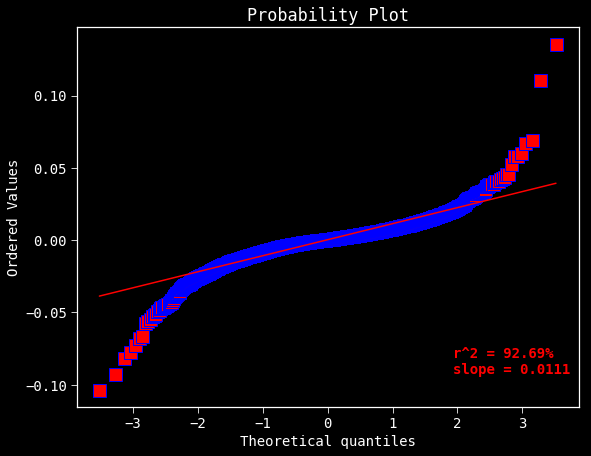

In [12]:
s = df[ex]
quantile_plot(s)

`As most of you already know SPY returns exhibit a phenomenon known as "fat tails" as clearly demonstrated by the above plot. All this means is that extreme returns, both positive and negative, occur at a much higher frequency than predicted by the normal distribution. When you read various papers, authors may also refer to this concept by saying "the distribution has more MASS in the TAILS". In this context they mean the same thing. So this shows that over the period of 12 years that SPY returns are not distributed according to the Normal distribution.`

`But, we haven't really addressed the stationary aspect, yet.`

`One way we can examine whether the returns are stationary is looking at the mean and standard deviation of returns by year. If those two quantities are not supposed to be a function of time then they should be pretty similar across years, right?`

CPU times: user 10.7 s, sys: 3.7 s, total: 14.4 s
Wall time: 10.4 s


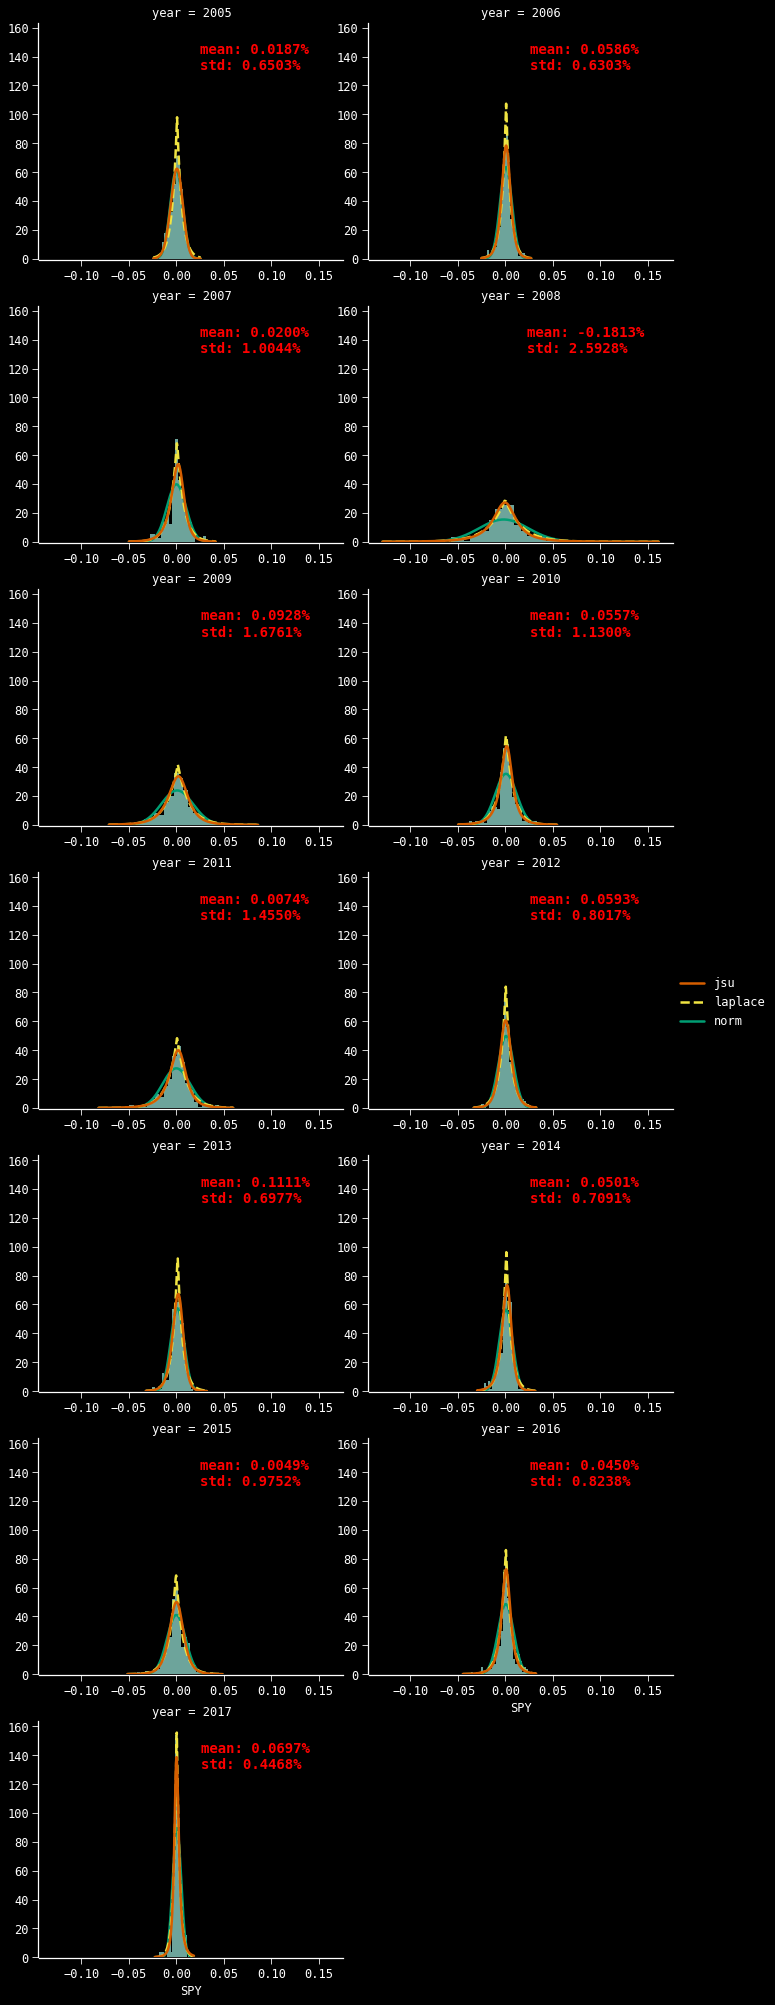

In [13]:
%%time

plot_facet_hist(df, ex)    

#### `The annual means and standard deviations vary signficantly across years.` 

`Just by eyeballing the plots you can see how varied the return distribution is. Sometimes the distribution is highly peaked like 2006 and 2017, and other times it's wider and flatter, like 2008-09. We can see a little bit of that variation more clearly below.`

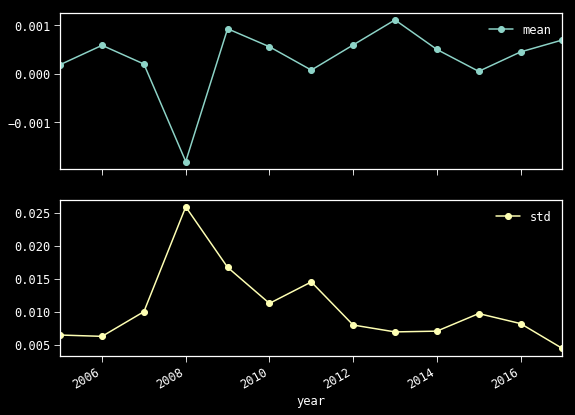

In [14]:
df.groupby('year')[ex].agg(['mean', 'std']).plot(marker='o', subplots=True);

`Did you notice the fitted normal density plots in the faceted histogram looked like it did a better job of approximating the returns for the individual years? Does that mean that our previous conclusion that returns are NOT normally distributed is simply a matter of the time scale? Let's look into this a little further with a faceted quantile plot.

In [39]:
def plot_facet_qq(rs, ex):
    """fn: to plot faceted quantile plots using FacetGrid
    
    # Args
        rs : pd.DataFrame()
        ex : str(), security/column name
    """
    g = (rs
         .pipe(sns.FacetGrid, 
               col='year',
               col_wrap=2,
               size=7,
               aspect=1.3)
         .map(quantile_plot, ex)
         .fig.subplots_adjust(hspace=0.2))
    sns.despine(offset=1, trim=True)
    return

CPU times: user 1.76 s, sys: 780 ms, total: 2.54 s
Wall time: 1.55 s


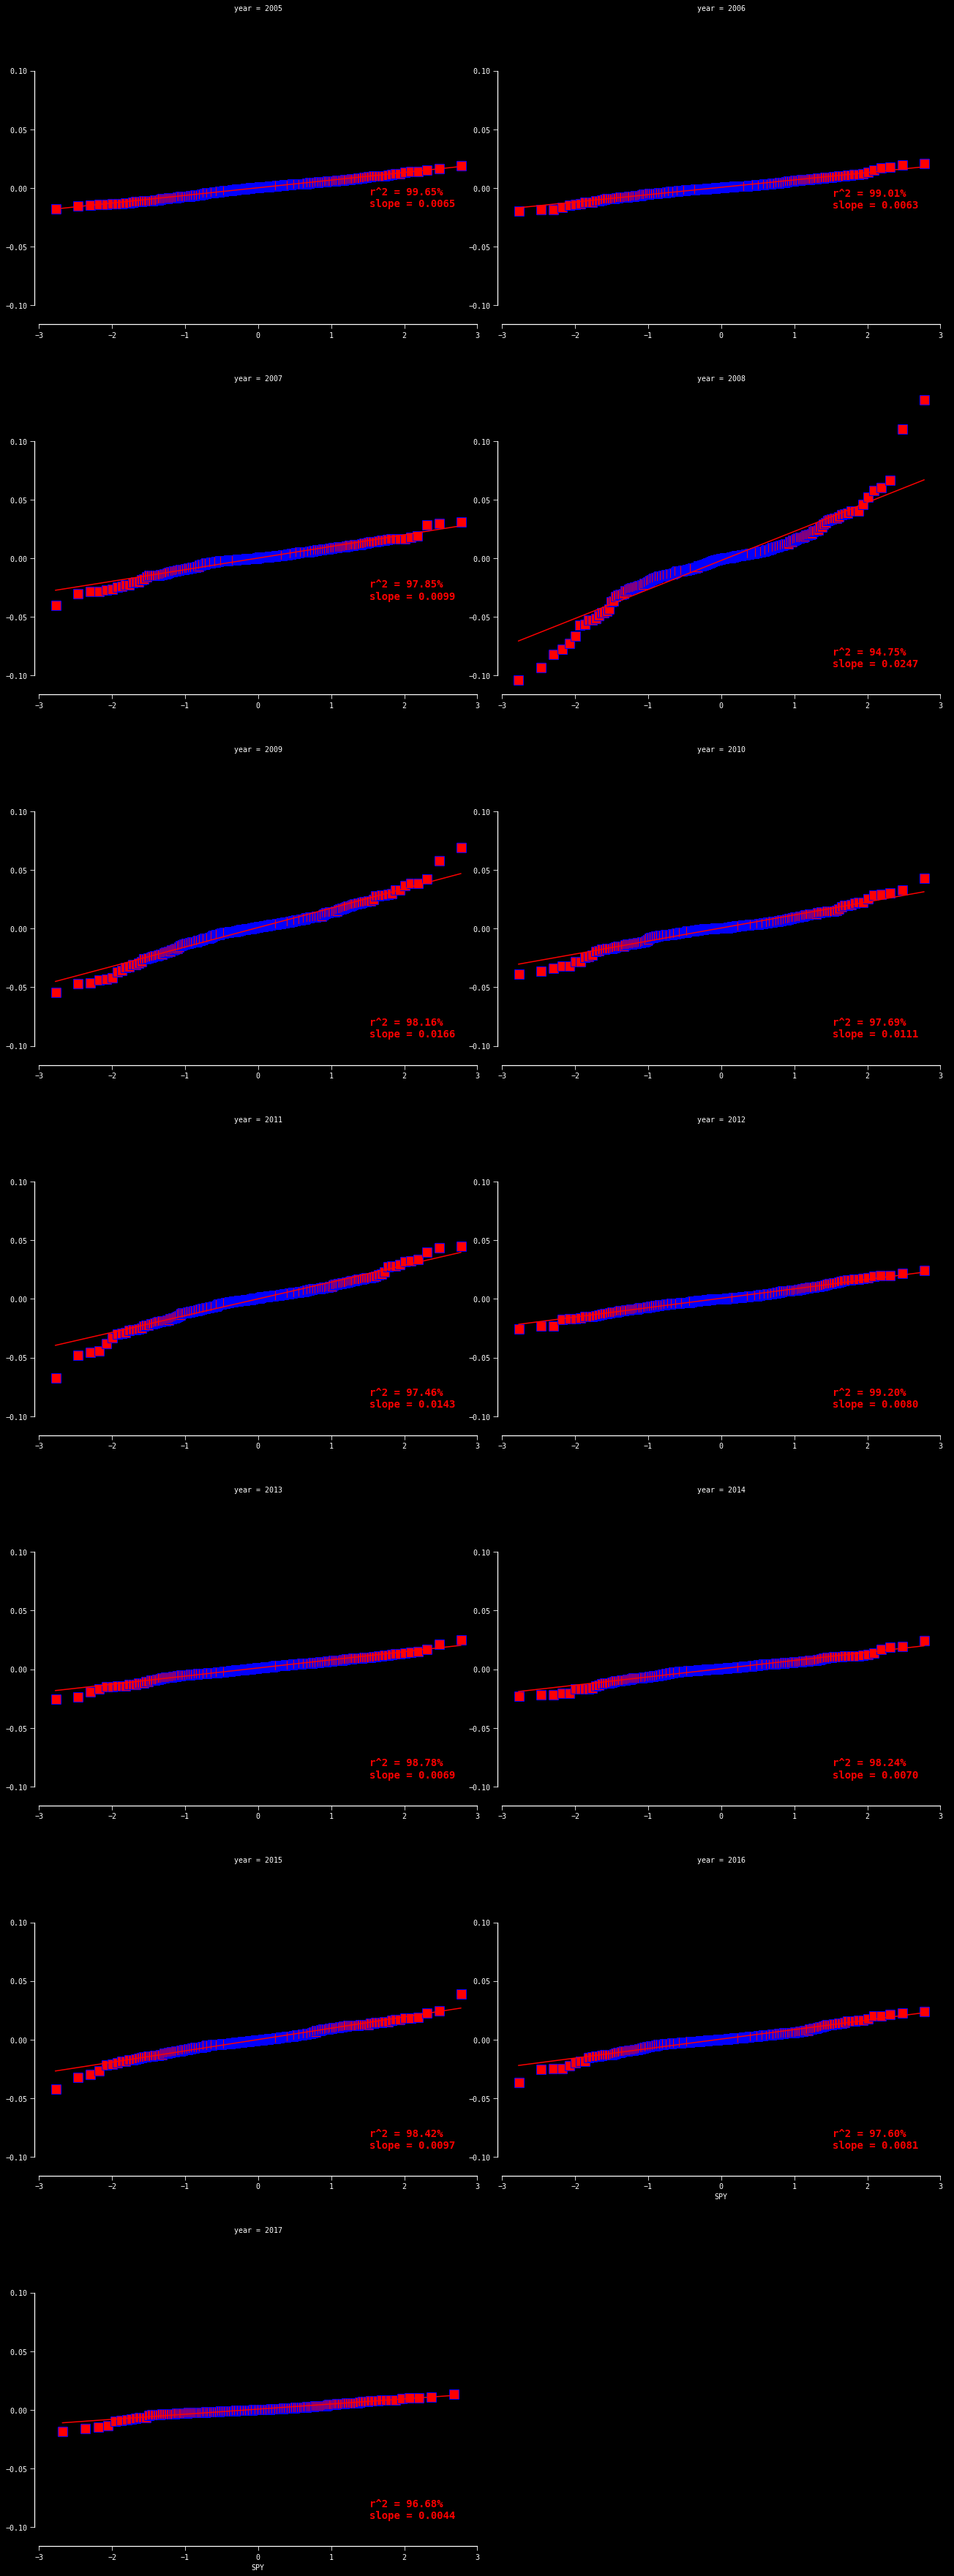

In [41]:
%time plot_facet_qq(df, ex)    

`Unsurprisingly we see that in certain years the return distribution is indistiguishable from a normally distributed approximation. In other years we see that the assumption of normality would have been disastrous. So we can say, by visual observation, that the means and variances of the return series are at minimum a function of time, a function of the time scale, and a function of the quantity of data points.` 

`What we can also observe is the effect of central bank intervention on US listed multinational corporations and their asset prices. In 2005-06 we can see return distributions are effectively normally distributed. By 2007 we can see that some returns were more negative and occuring with more frequency than predicted using normal approximation. By 2008 the wheels were falling off the bus and the volatility and magnitude of the returns, both postive and negative, were highly non-normal. 2009-10 marks the time that the Fed stepped in to stabilize markets. However it was not enough, as the financial "contagion" had spread globally and especially to European markets. 2011 was the Euro-Crisis and we can see similar non-normal return pattern returns, especially negative returns. Then the global recapitalization aka global debt monetization scheme kicked in around 2012 and we've seen an unprecedented decline in volatility and return dispersion.`

In [17]:
norm = stats.norm

def generate_norm_rvs(ser, N=None):
    if not N: N = ser.shape[0]
    return norm.rvs(ser.mean(), ser.std(), size=N, random_state=RANDOM_STATE)
    
def generate_norm_pdf(ser, N=None):
    if not N: N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = norm.pdf(x, ser.mean(), ser.std())
    return x, y

def generate_norm_cdf(ser, N=None):
    if not N: N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = norm.cdf(x, ser.mean(), ser.std())
    return x, y

#### `The final test - Kolmogorov-Smirnov. `

`Let's test this more rigorously. For this we will use the CDF of the returns and compare those with a fitted or empirical CDF using the kolmogorov-smirnov two sample test (`scipy.stats.kstest`). This test will allow us to moore definitively state whether the CDF of the two series come from the same distribution e.g. the Normal distribution. the kstest outputs the ks statistic and a p-value. P-values less than 0.05 means we can reject the null hypothesis that the two series were drawn from the same distribution. The smaller the p-value the more confident we are that they came from different distributions.`

`First we will analyze the entire return series, then compare the test across years.`

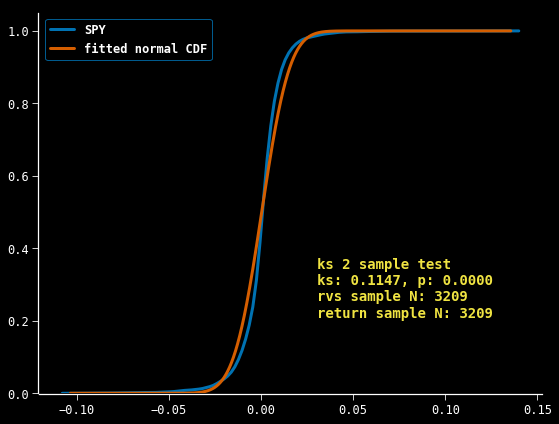

In [18]:
def plot_cdf(ser, **kwds):   
    """fn: to plot single CDF comparison
    
    # Args
        ser : pd.Series()
    """
    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'dejavu sans mono'
    
    # plot kde
    g = sns.kdeplot(ser, cumulative=True, lw=3, color=blue)
    
    x, y = generate_norm_cdf(ser) # generate fitted normal CDF
    g.plot(x, y, color=red, lw=3, label='fitted normal CDF')
    
    # 2 sided ks test
    #  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
    ks, p = stats.kstest(ser, 'norm', args=(ser.mean(), ser.std()))
    
    xmin,xmax=plt.gca().get_xlim()
    ymin,ymax=plt.gca().get_ylim()

    # add text
    txkw = dict(size=14, fontweight='demi', color=gold, rotation=0)
    tx_N = ser.shape[0]
    tx_args = (ks, p, tx_N, ser.shape[0])
    tx = 'ks 2 sample test\nks: {:.4f}, p: {:.4f}\nrvs sample N: {:.0f}\nreturn sample N: {:.0f}'.format(*tx_args)
    plt.text(xmax*0.2, 0.2*ymax, tx, **txkw)    
    
    sns.despine(offset=1)
    (plt.legend(frameon=True, prop={'weight':'demi', 'size':12})
     .get_frame()
     .set_edgecolor(blue))
    return

plot_cdf(df[ex])    

`This further confirms our assumption that the two series are in fact drawn from seperate distros. Let's look at the same information by year.`

CPU times: user 4.71 s, sys: 2.22 s, total: 6.93 s
Wall time: 4.42 s


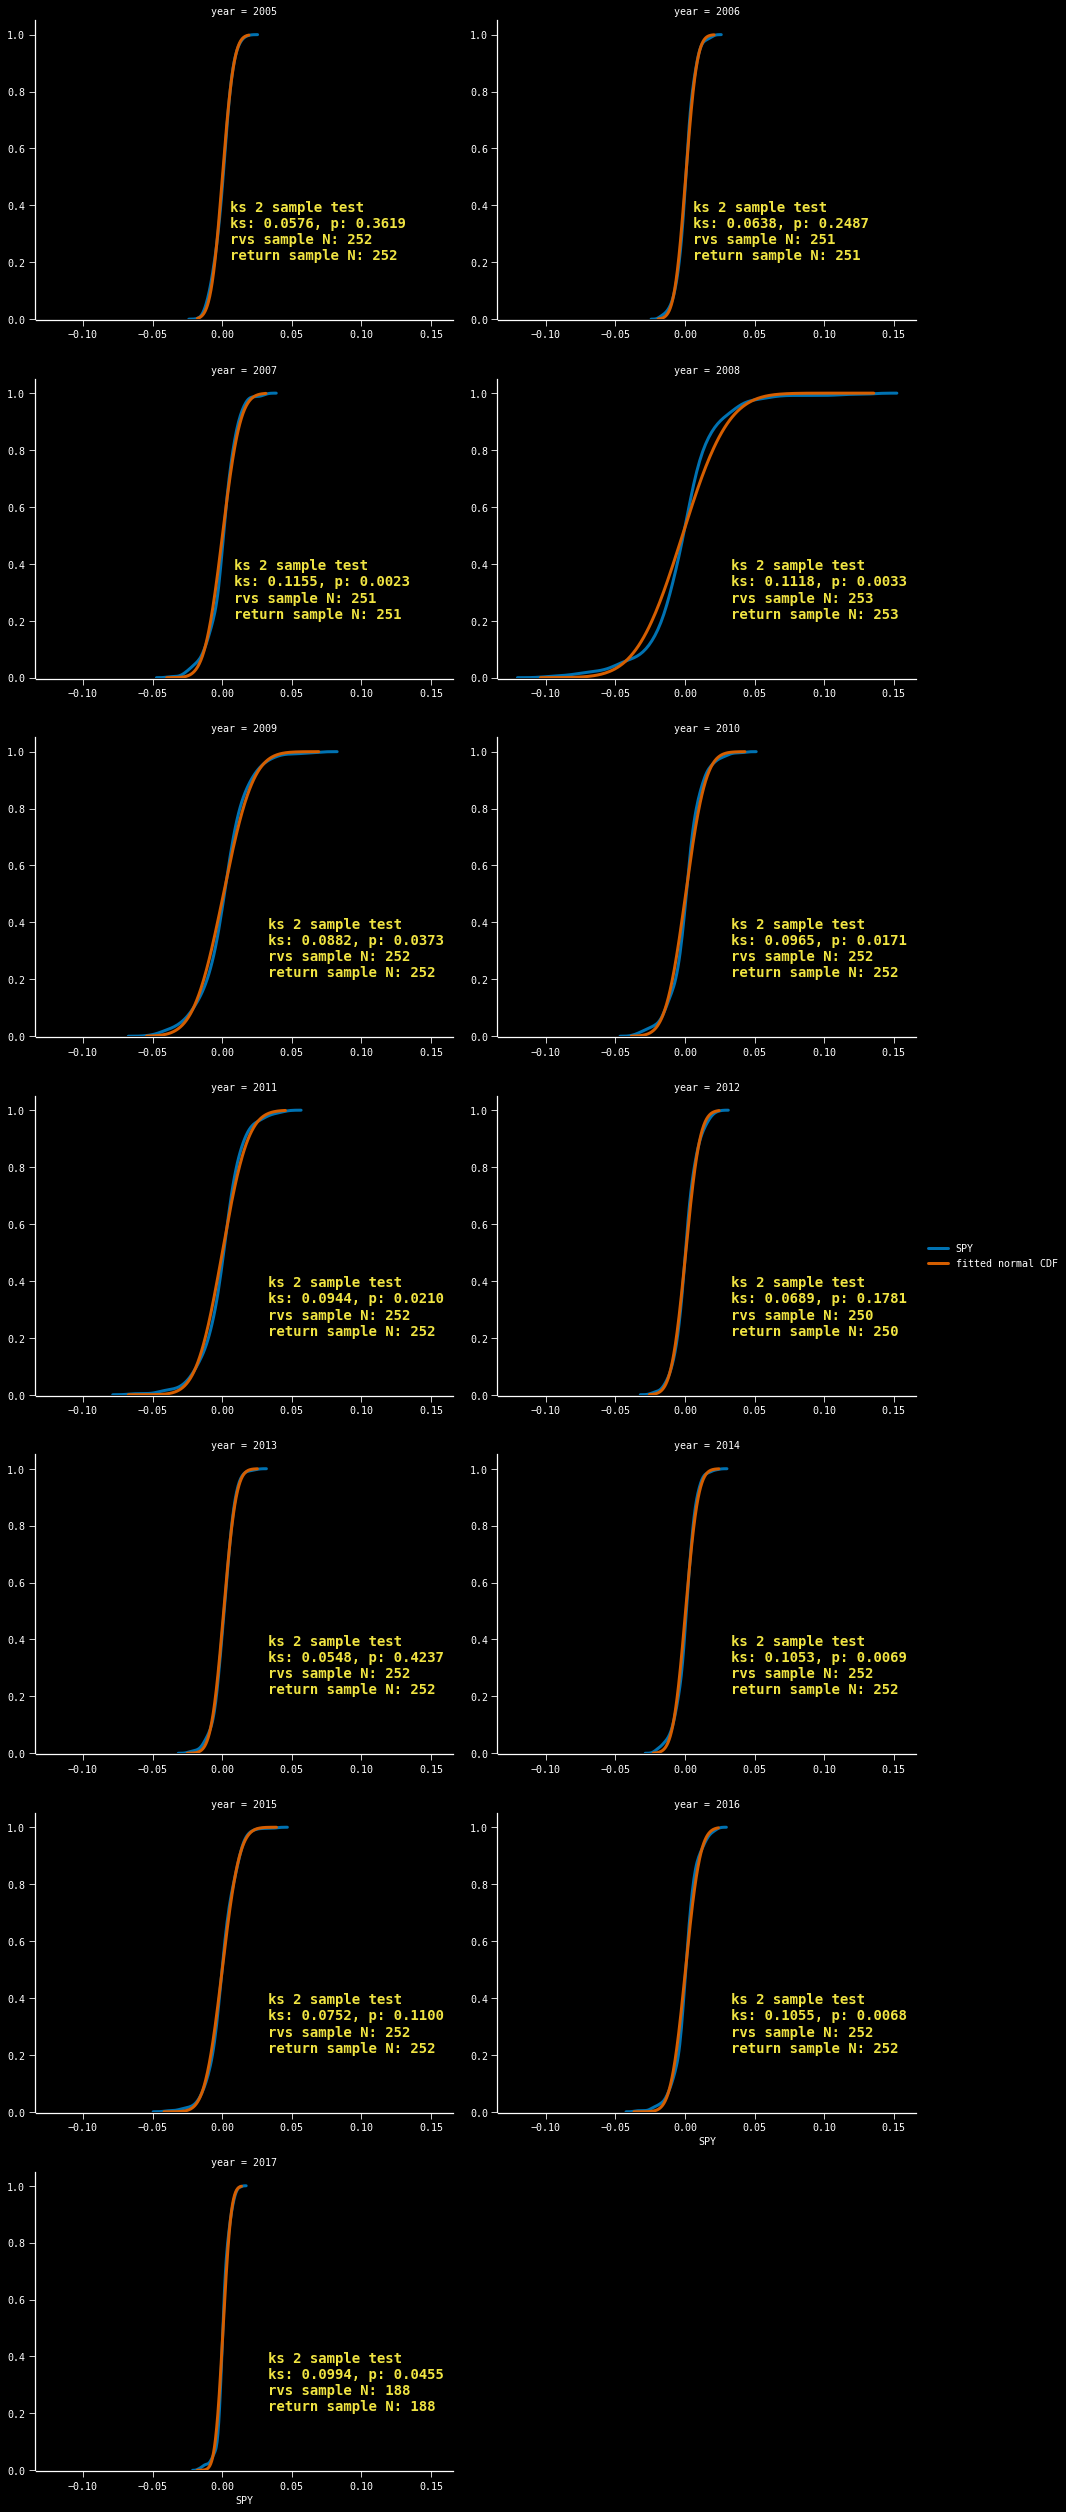

In [42]:
def plot_facet_cdf(rs, ex, **kwds):
    """fn: to plot single distro with fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), returns dataframe
        ex : str(), security/column name
    """
    g = (rs
         .pipe(sns.FacetGrid, 
               col='year',
               col_wrap=2,
               size=5,
               aspect=1.3)
         .map(plot_cdf, ex, **kwds))
    g.add_legend()
    g.fig.subplots_adjust(hspace=.20)
    sns.despine(offset=1)
    return

%time plot_facet_cdf(df, ex)

`From 2007-11 the kstest is pretty confident that the return CDF and the fitted normal ECDF are different as the p-values are smaller than our arbitrary threshold of 0.05. From 2012-13, and 2015 the kstest doesn't see a difference between them. And in 2014, and from 2016-17 the kstest tells us they came from different distributions.`

CPU times: user 55.6 s, sys: 17.2 s, total: 1min 12s
Wall time: 52.7 s


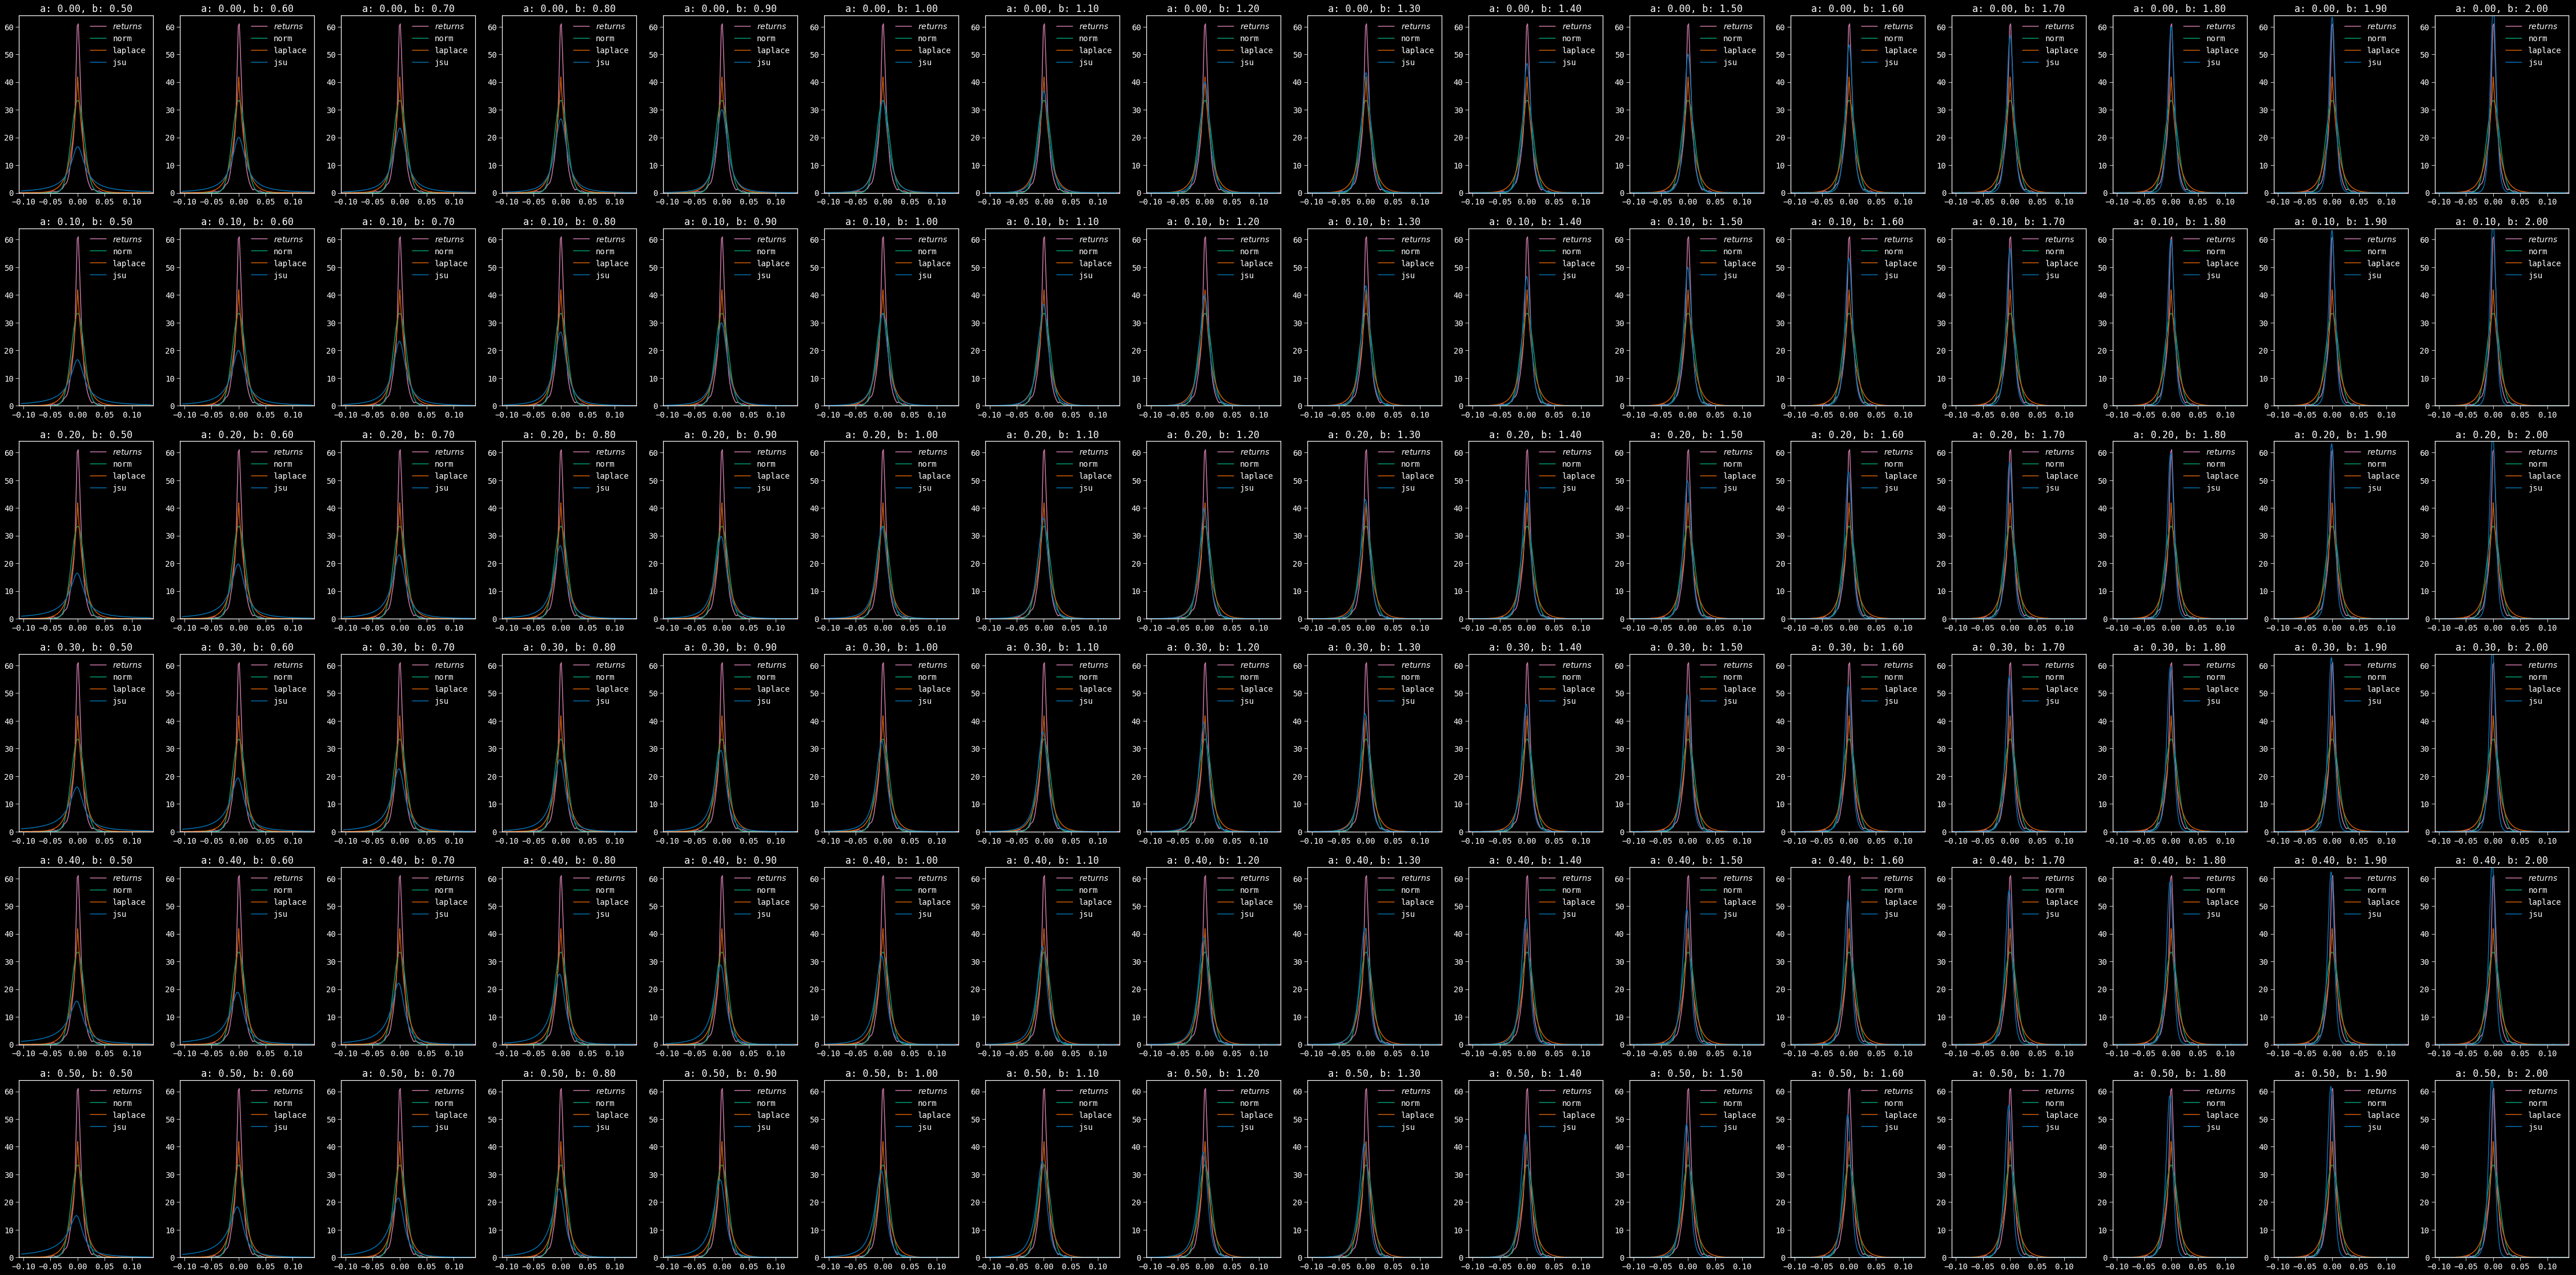

In [18]:
laplace = stats.laplace
jsu = stats.johnsonsu

def generate_laplace_rvs(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = laplace(ser.mean(), ser.std()).pdf(x)
    return x, y

def generate_laplace_cdf(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = laplace.cdf(x, ser.mean(), ser.std())
    return x, y

def generate_jsu_rvs(ser, a, b):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = jsu(a, b, loc=ser.mean(), scale=ser.std()).pdf(x)
    return x, y

def generate_jsu_cdf(ser, a, b):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = jsu.cdf(x, a, b, loc=ser.mean(), scale=ser.std())
    return x, y


def plot_all_pdf(ex, a, b, ax=None):
    normx, normy = generate_norm_rvs(ex)
    lpcx, lpcy = generate_laplace_rvs(ex)
    jsux, jsuy = generate_jsu_rvs(ex, a, b)

    if not ax:
        fig, ax = plt.subplots()
    sns.kdeplot(ex, ax=ax, color=purple, label='$returns$')
    pd.Series(normy, index=normx).plot(ax=ax, color=green, label='norm')
    pd.Series(lpcy, index=lpcx).plot(ax=ax, color=red, label='laplace')
    pd.Series(jsuy, index=jsux).plot(ax=ax, color=blue, label='jsu')
    plt.legend()

inc = 0.1
_as = np.arange(0.0, 0.5+inc, inc)
_bs = np.arange(0.5, 2.+inc, inc)    
len(_as) * len(_bs)

%%time

gs = gridspec.GridSpec(len(_as), len(_bs))

fig = plt.figure(figsize=(80,40))

for i, a in enumerate(_as):
    for j, b in enumerate(_bs):
        tmp_ax = plt.subplot(gs[i, j])
        plot_all_pdf(ex, a, b, ax=tmp_ax)
        plt.title('a: {:.2f}, b: {:.2f}'.format(a, b))
plt.savefig('spy return pdf compare.png', dpi=300, bbox_inches='tight')

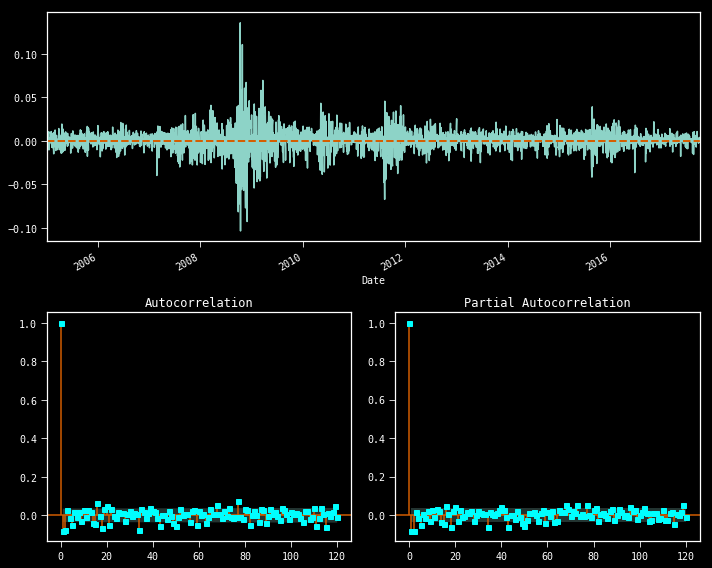

In [38]:
def tsplot(y, lags=None, **kwds):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'dejavu sans mono'        
        
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.axhline(0, color=red, ls='--', lw=2.)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, color=red)
    acf_ax.get_lines()[1].set_marker('s');
    acf_ax.get_lines()[1].set_markerfacecolor('cyan');
    acf_ax.get_lines()[1].set_markeredgecolor('cyan');

    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, color=red)
    pacf_ax.get_lines()[1].set_marker('s');
    pacf_ax.get_lines()[1].set_markerfacecolor('cyan');
    pacf_ax.get_lines()[1].set_markeredgecolor('cyan');

    plt.tight_layout()
    return

tsplot(df[ex], lags=120);

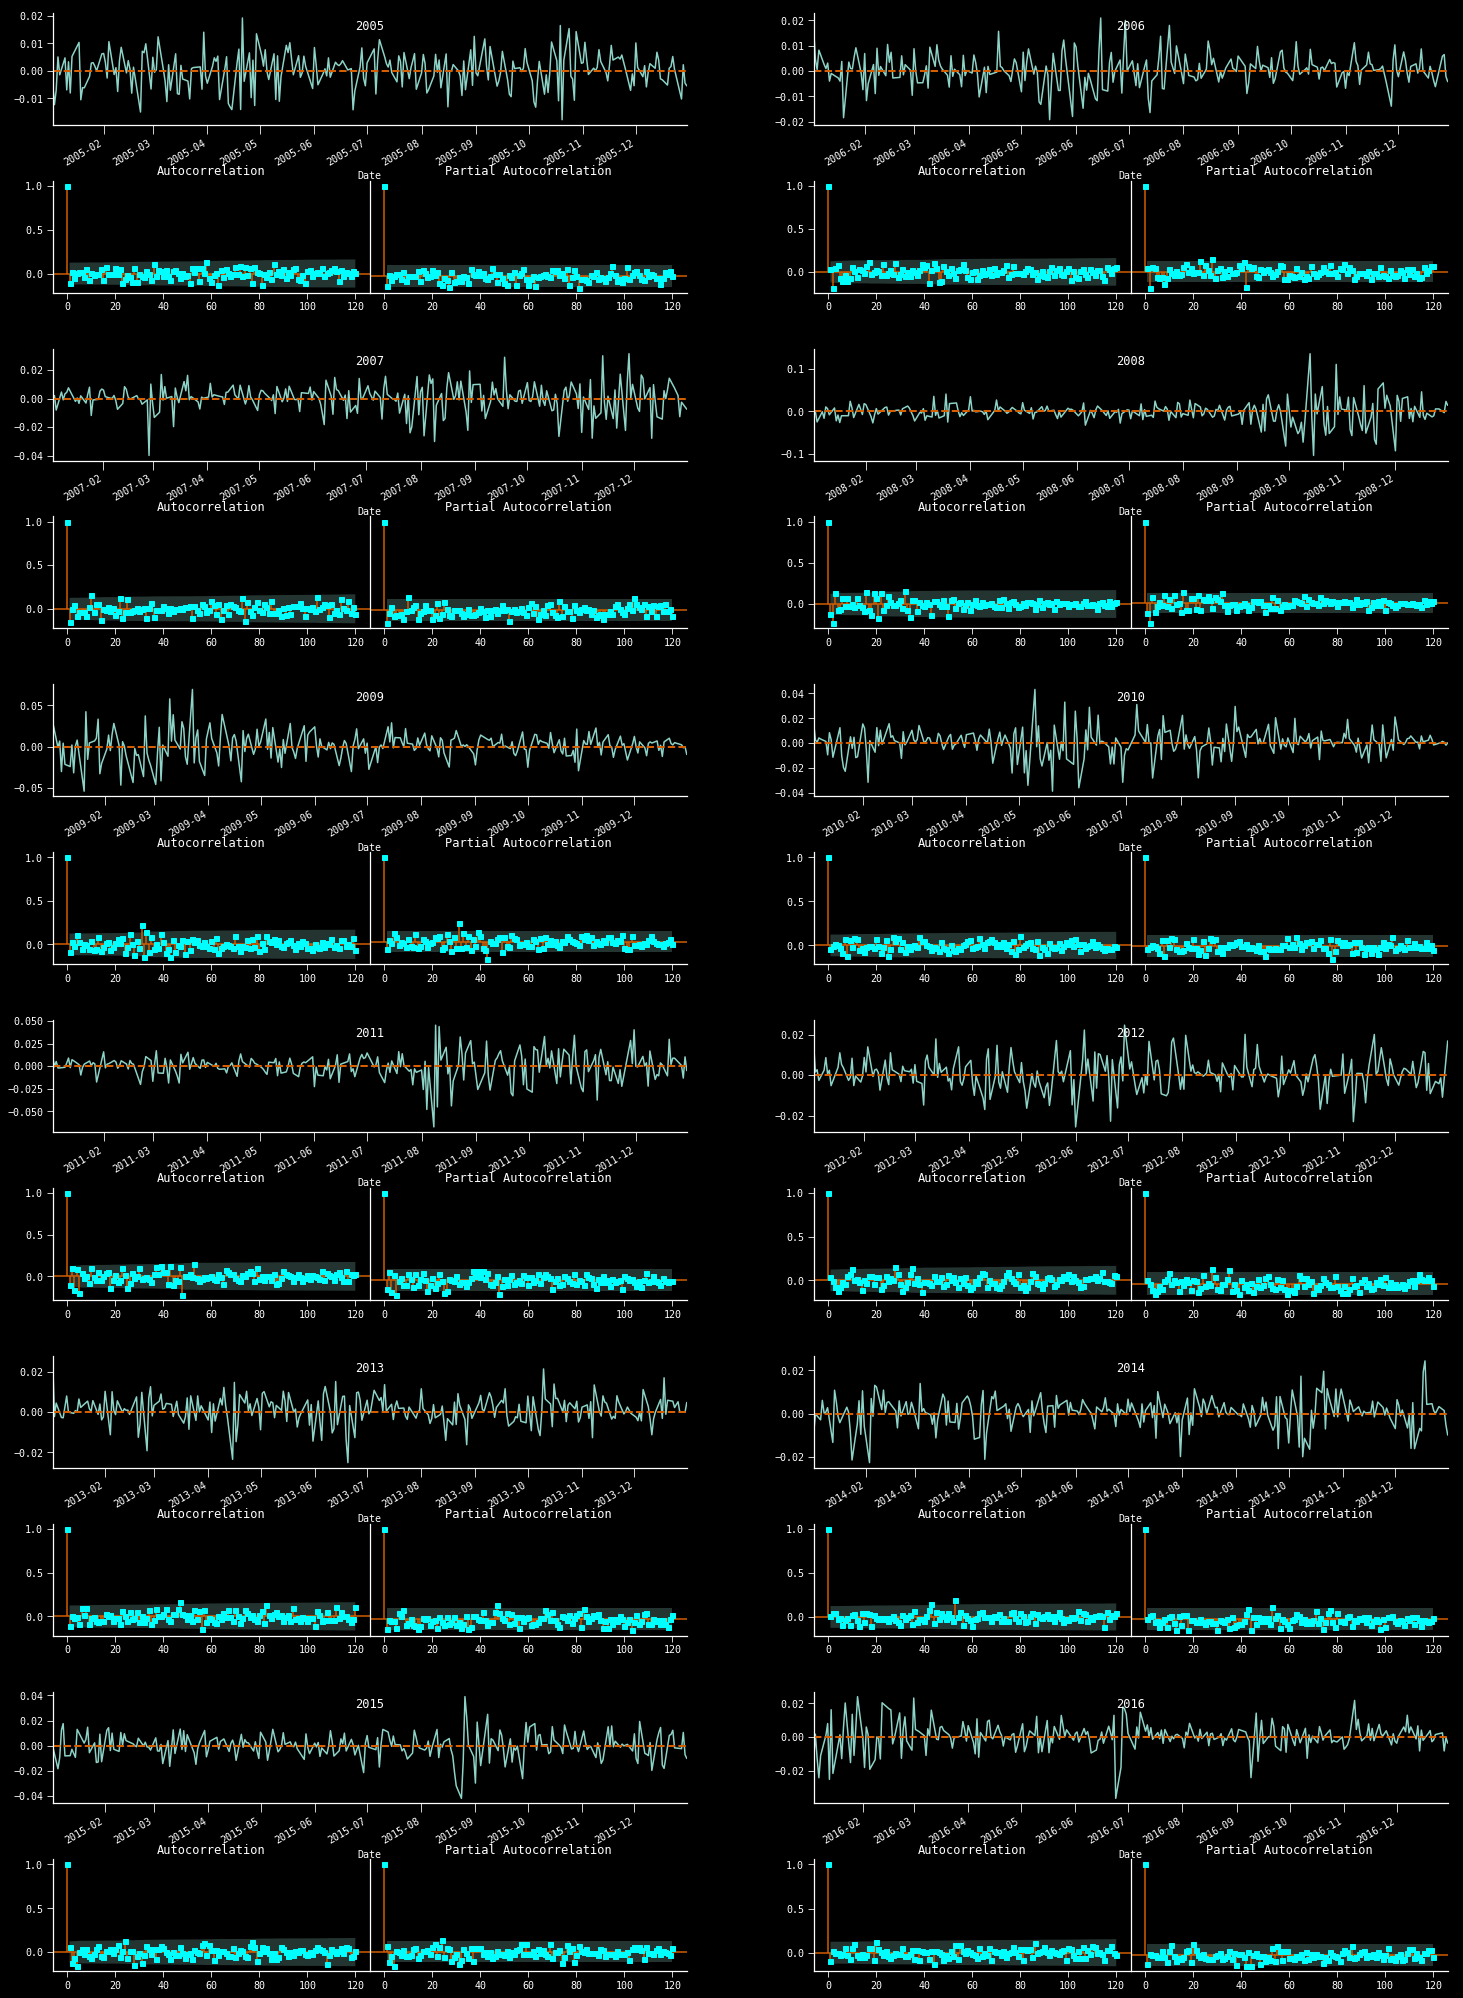

In [33]:

def facet_tsplot(df, ex, *args):
    """fn: to plot faceted timeseries plot using gridspec
    
    # Args 
        df : pd.DataFrame(), return data
        ex : str(), etf symbol
        _lags : numeric
        _years : array-like, list of years
        _dt : int(), number of columns
        _partial_len : int(), number of rows
    """
    plt.style.use('dark_background')
    
    fig = plt.figure(figsize=(25,40))
    outer_grid = gridspec.GridSpec(_partial_len, _dt)

    for i, year in zip(range(int(_partial_len*_dt)), _years):        
        y = df[ex].loc[str(year)]    

        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2,
                                                      subplot_spec=outer_grid[i],
                                                      wspace=0.0, hspace=0.5)

        ts_ax = plt.Subplot(fig, inner_grid[0, :])
        acf_ax = plt.Subplot(fig, inner_grid[1, 0])
        pacf_ax = plt.Subplot(fig, inner_grid[1, -1])

        y.plot(ax=ts_ax)
        ts_ax.axhline(0, color=red, ls='--', lw=2.)
        ts_ax.tick_params(axis='x', size=9)
        ts_ax.set_title(str(year), y=.8)

        smt.graphics.plot_acf(y, lags=_lags, ax=acf_ax, alpha=0.05, color=red)
        acf_ax.get_lines()[1].set_marker('s');
        acf_ax.get_lines()[1].set_markerfacecolor('cyan');
        acf_ax.get_lines()[1].set_markeredgecolor('cyan');

        smt.graphics.plot_pacf(y, lags=_lags, ax=pacf_ax, alpha=0.05, color=red)
        pacf_ax.get_lines()[1].set_marker('s');
        pacf_ax.get_lines()[1].set_markerfacecolor('cyan');
        pacf_ax.get_lines()[1].set_markeredgecolor('cyan');
        pacf_ax.set_yticks([])

        fig.add_subplot(ts_ax)
        fig.add_subplot(acf_ax)
        fig.add_subplot(pacf_ax)

        sns.despine()

    plt.show()
    return


_years = np.arange(df.year.min(), df.year.max())
# array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

_dt = 2
_partial_len = int(len(_years)/_dt)
_lags = 120

facet_tsplot(df, ex, _lags, _years, _dt, _partial_len)    

So we can see clearly that SPY returns are nonstationary in the mean, in the variance, and demonstrate periods of variable autocorrelation. Furthermore we see the return distribution is mostly non-normal. So what happens when we try to use past returns approximated by a normal distribution's summary metrics (mean, variance) to predict future return distributions?

In [28]:
from sklearn.model_selection import TimeSeriesSplit

TimeSeriesSplit(max_train_size=3, n_splits=3)
[0 1 2] [3]
[1 2 3] [4]
[2 3 4] [5]


In [41]:
xx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 1 columns):
SPY    3209 non-null float64
dtypes: float64(1)
memory usage: 210.1 KB


In [71]:
_base = 252 # 1 trading year
_max_train_sizes = [_base*1, _base*2, _base*3, _base*5]
_splits = np.arange(2, 12, 2)

sum([len(_max_train_sizes) * i for i in _splits]), _splits, _splits.sum()

(120, array([ 2,  4,  6,  8, 10]), 30)

In [ ]:
%%time

xx = df[ex].copy() # pd series representing example data

gs = gridspec.GridSpec(_splits.sum(), len(_max_train_sizes))

fig = plt.figure(figsize=(40,90))

n_split=5 # try with different values

rows = []
for j, max_size in enumerate(_max_train_sizes):
    tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=max_size)
    
    for i, (train, test) in enumerate(tscv.split(xx)):
        tmp_train = xx.iloc[train] # temporary train data
        tmp_test = xx.iloc[test] # temporary test data
        
        # get date ranges for datasets
        min_train_dt, max_train_dt = tmp_train.index.min(), tmp_train.index.max()
        min_test_dt, max_test_dt = tmp_test.index.min(), tmp_test.index.max()
        
        # compare train distro vs test distro 
        #   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
        ks, p = stats.ks_2samp(tmp_train, tmp_test) # get ks statistic and pvalue
        
        df_row = (max_size, ks, p, min_train_dt.date(), max_train_dt.date(), min_test_dt.date(), max_test_dt.date())
        rows.append(df_row) # append data for df
        
        tmp_ax = plt.subplot(gs[i, j]) # get temp ax from gridspec object
        sns.kdeplot(tmp_train, cumulative=True, lw=3, color=blue, ax=tmp_ax, label='train')
        sns.kdeplot(tmp_test, cumulative=True, lw=3, color=red, ax=tmp_ax, label='test')
        plt.title('max train size: {}, ks: {:.4f}, p: {:.4f}\ntrain dates: {}_{}\ntest dates: {}_{}'
                  .format(max_size, ks, p,
                          min_train_dt.date(), max_train_dt.date(),
                          min_test_dt.date(), max_test_dt.date()), 
                  fontsize=11.)
        plt.subplots_adjust(top=1.03) # adjust title spacing
        plt.tight_layout()
#plt.savefig('spy return cdf compare-time series split {} folds-kstest.png'.format(n_split), dpi=300, bbox_inches='tight') 

In [104]:
# create data table with ks test results and tss information

cols = ['max_size', 'ks', 'p', 'min_train_dt', 'max_train_dt', 'min_test_dt', 'max_test_dt']
tss_ks_df = pd.DataFrame(rows, columns=cols)
obj_cols = tss_ks_df.select_dtypes(include=['object']).columns
tss_ks_df[obj_cols] = tss_ks_df[obj_cols].apply(pd.to_datetime)
tss_ks_df

,max_size,ks,p,min_train_dt,max_train_dt,min_test_dt,max_test_dt
0,252,0.2284,0.0000,2006-02-23,2007-02-23,2007-02-26,2009-04-07
1,252,0.2067,0.0000,2008-04-09,2009-04-07,2009-04-08,2011-05-19
2,252,0.0491,0.7941,2010-05-21,2011-05-19,2011-05-20,2013-07-05
3,252,0.0490,0.7950,2012-07-03,2013-07-05,2013-07-08,2015-08-18
4,252,0.0817,0.1945,2014-08-19,2015-08-18,2015-08-19,2017-09-29
5,504,0.2077,0.0000,2005-02-23,2007-02-23,2007-02-26,2009-04-07
6,504,0.1505,0.0000,2007-04-10,2009-04-07,2009-04-08,2011-05-19
7,504,0.0492,0.5460,2009-05-21,2011-05-19,2011-05-20,2013-07-05
8,504,0.0887,0.0316,2011-07-05,2013-07-05,2013-07-08,2015-08-18
9,504,0.0632,0.2442,2013-08-19,2015-08-18,2015-08-19,2017-09-29


In [110]:
get_pct_reject = lambda df, col, alpha: df.query('{} < {}'.format(col, alpha)).shape[0] / df.shape[0]

a1 = 0.05
a2 = 0.01

get_pct_reject(tss_ks_df, 'p', a1), get_pct_reject(tss_ks_df, 'p', a2) 

(0.6, 0.35)

In [111]:
tss_ks_df.query('p > 0.05')

,max_size,ks,p,min_train_dt,max_train_dt,min_test_dt,max_test_dt
2,252,0.0491,0.7941,2010-05-21,2011-05-19,2011-05-20,2013-07-05
3,252,0.0490,0.7950,2012-07-03,2013-07-05,2013-07-08,2015-08-18
4,252,0.0817,0.1945,2014-08-19,2015-08-18,2015-08-19,2017-09-29
7,504,0.0492,0.5460,2009-05-21,2011-05-19,2011-05-20,2013-07-05
9,504,0.0632,0.2442,2013-08-19,2015-08-18,2015-08-19,2017-09-29
14,756,0.0657,0.1291,2012-08-15,2015-08-18,2015-08-19,2017-09-29
16,1260,0.0664,0.0829,2005-01-03,2009-04-07,2009-04-08,2011-05-19
17,1260,0.0426,0.4949,2006-05-19,2011-05-19,2011-05-20,2013-07-05


Unsurprisingly the results are terrible. It's almost like they came from two different distributions (shocker). 

In [53]:
# demonstrate with the laplace and johnson su dist

For this example lets assume the total return is series is length $N$.

What if we were to look at the each year's summary statistics as being sourced from _$K$_ different distributions with $K << N$? 

To elaborate, we can look across the time series and try to guess which year's returns come from distribution $k_1$, $k_2$...$k_m$. Building on that concept then, if our distribution assignment is good enough(c) we can use the parameters for $k_i$ with returns $r$ ~ ($\mu_i$,$\sigma_i$), as the input to our predicted future return distribution.